# DDPM Training
This notebook contains my first learning artifact; implementing Denoising Diffusion Probabilistic Models (DDPM) within pytorch to train and generate MNIST images.

This includes loading the dataset & model, and the additional DDPM relation functions for training. 


## Importing libraries
Nothing special here, mainly just pytorch & matplotlib 

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

## Hyperparameters
Defining hyperparameters for training and DDPM.

In [ ]:
img_size = 28
channels = 1
timesteps = 1000
batch_size = 128
epochs = 10
learning_rate = 1e-4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Model Definitions

The UNet architecture that will be used to train & generate new samples. 

Please note; I was kinda lazy and so I mainly used a template I found [on github](https://github.com/clemkoa/u-net/blob/master/unet/unet.py). My primary modifications are implementing time embedding functionality to the architecture (as noted by the original DDPM paper), otherwise it's exceedingly normal.

In [ ]:
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        x = self.conv(x)
        return x

class Up(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(Up, self).__init__()
        self.up_scale = nn.ConvTranspose2d(in_ch, out_ch, kernel_size=2, stride=2)

    def forward(self, x1, x2):
        x2 = self.up_scale(x2)

        diffY = x1.size()[2] - x2.size()[2]
        diffX = x1.size()[3] - x2.size()[3]

        x2 = F.pad(x2, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return x


class DownLayer(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(DownLayer, self).__init__()
        self.pool = nn.MaxPool2d(2, stride=2, padding=0)
        self.conv = DoubleConv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(self.pool(x))
        return x


class UpLayer(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(UpLayer, self).__init__()
        self.up = Up(in_ch, out_ch)
        self.conv = DoubleConv(in_ch, out_ch)

    def forward(self, x1, x2):
        a = self.up(x1, x2)
        x = self.conv(a)
        return x


class UNet(nn.Module):
	def __init__(self, channels=1, time_dim=128):
		super(UNet, self).__init__()
		self.conv1 = DoubleConv(channels, 64)
		self.down1 = DownLayer(64, 128)
		self.down2 = DownLayer(128, 256)
		self.down3 = DownLayer(256, 512)
		self.down4 = DownLayer(512, 1024)
		self.up1 = UpLayer(1024, 512)
		self.up2 = UpLayer(512, 256)
		self.up3 = UpLayer(256, 128)
		self.up4 = UpLayer(128, 64)
		self.last_conv = nn.Conv2d(64, channels, 1)

		self.time_embed = nn.Embedding(timesteps, time_dim)
		self.time_proj = nn.Linear(time_dim, 64)

	def forward(self, x, t):

		t_embed = self.time_embed(t)
		t_embed = F.relu(self.time_proj(t_embed))

		x1 = self.conv1(x) + t_embed.view(-1, 64, 1, 1)
		x2 = self.down1(x1)
		x3 = self.down2(x2)
		x4 = self.down3(x3)
		x5 = self.down4(x4)
		x1_up = self.up1(x4, x5)
		x2_up = self.up2(x3, x1_up)
		x3_up = self.up3(x2, x2_up)
		x4_up = self.up4(x1, x3_up)
		output = self.last_conv(x4_up)
		return output


## Primary DDPM, Training, & Sampling Functions

While there's a lot of information in the original paper, it's a little math-heavy and difficult to read. 

Thats why the following functions are loosely inspired from [OpenAI's improved DDPM repo](https://github.com/openai/improved-diffusion/blob/main/improved_diffusion/resample.py)

In [ ]:
# DDPM schedules
def beta_schedule(timesteps):
	# Linearly spaced noise variance values (how much noise is added at each forward diffusion step)
	betas = torch.linspace(0.0001, 0.02, timesteps).to(device)

	# How much of the original image remains
	alphas = 1.0 - betas

	# Total signal preserved up till t
	alphas_cumprod = torch.cumprod(alphas, dim=0)

	return betas, alphas, alphas_cumprod

betas, alphas, alphas_cumprod = beta_schedule(timesteps)

# Forward diffusion process: q(x_t | x_0)
def q_sample(x_0, t, noise=None):
	if noise is None:
		noise = torch.randn_like(x_0).to(device) # gaussian noise

	# amount of original image signal remaining at step t
	sqrt_alphas_cumprod_t = torch.sqrt(alphas_cumprod[t]).view(-1, 1, 1, 1)
	
	# amount of noise added at step t
	sqrt_one_minus_alphas_cumprod_t = torch.sqrt(1.0 - alphas_cumprod[t]).view(-1, 1, 1, 1)

	# returned noisy image
	return sqrt_alphas_cumprod_t * x_0 + sqrt_one_minus_alphas_cumprod_t * noise

# Training
def train(model, dataloader, optimizer):
	model.train()
	losses = []
	for epoch in range(epochs):
		for batch_idx, (data, _) in enumerate(dataloader):
			
			# Normal data loading
			data = data.to(device)
			optimizer.zero_grad()
			t = torch.randint(0, timesteps, (data.size(0),), device=device) # Random time step for each image
			noise = torch.randn_like(data).to(device)

			# Actually create the noisy images
			x_t = q_sample(data, t, noise)

			# Get the model to predict the noise
			predicted_noise = model(x_t, t)

			# Calculate loss and back propagate
			loss = F.mse_loss(predicted_noise, noise)
			loss.backward()
			optimizer.step()

			# Logging
			if batch_idx % 100 == 0:
				print(f'Epoch {epoch}, Batch {batch_idx}, Loss: {loss.item():.4f}')
				losses.append(loss.item())
	
	return losses

# Sampling
@torch.no_grad()
def sample(model, n_samples):
	model.eval()
	
	# Start with gaussian noise
	x = torch.randn(n_samples, channels, img_size, img_size).to(device)

	# Reverse process
	for t in reversed(range(timesteps)):
		
		# Current time step
		t_tensor = torch.full((n_samples,), t, device=device, dtype=torch.long)
		
		# Take a guess
		predicted_noise = model(x, t_tensor)
		
		# How much noise *should've* been added
		beta_t = betas[t].view(-1, 1, 1, 1)

		# How much of the original image should remain
		alpha_t = alphas[t].view(-1, 1, 1, 1)

		# Basically the reverse of q_sample(), mainly undoing the noise in the image
		# Uses this nightmare of a formula to account for the expected noise & signal that is still in the image
		x = (1 / torch.sqrt(alpha_t)) * (x - ((1 - alpha_t) / torch.sqrt(1 - alphas_cumprod[t])) * predicted_noise)
		
		# Not at the final step, add noise back in
		if t > 0:
			x += torch.sqrt(beta_t) * torch.randn_like(x)
	
	return (x.clamp(-1, 1) + 1) / 2



## Loading the required classes for training
Nothing too special here. Loading & shuffling MNIST, then setting up the model & optimiser

In [ ]:
# Data loading
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Model and optimizer
model = UNet(channels).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [37]:
# Train
losses = train(model, dataloader, optimizer)

Epoch 0, Batch 0, Loss: 1.1295
Epoch 0, Batch 100, Loss: 0.1056
Epoch 0, Batch 200, Loss: 0.0704
Epoch 0, Batch 300, Loss: 0.0687
Epoch 0, Batch 400, Loss: 0.0768
Epoch 1, Batch 0, Loss: 0.0636
Epoch 1, Batch 100, Loss: 0.0567
Epoch 1, Batch 200, Loss: 0.0430
Epoch 1, Batch 300, Loss: 0.0537
Epoch 1, Batch 400, Loss: 0.0475
Epoch 2, Batch 0, Loss: 0.0595
Epoch 2, Batch 100, Loss: 0.0386
Epoch 2, Batch 200, Loss: 0.0383
Epoch 2, Batch 300, Loss: 0.0414
Epoch 2, Batch 400, Loss: 0.0393
Epoch 3, Batch 0, Loss: 0.0447
Epoch 3, Batch 100, Loss: 0.0381
Epoch 3, Batch 200, Loss: 0.0350
Epoch 3, Batch 300, Loss: 0.0379
Epoch 3, Batch 400, Loss: 0.0420
Epoch 4, Batch 0, Loss: 0.0333
Epoch 4, Batch 100, Loss: 0.0333
Epoch 4, Batch 200, Loss: 0.0455
Epoch 4, Batch 300, Loss: 0.0478
Epoch 4, Batch 400, Loss: 0.0271
Epoch 5, Batch 0, Loss: 0.0291
Epoch 5, Batch 100, Loss: 0.0309
Epoch 5, Batch 200, Loss: 0.0386
Epoch 5, Batch 300, Loss: 0.0362
Epoch 5, Batch 400, Loss: 0.0359
Epoch 6, Batch 0, Loss

## Plotting loss history
Hopefully shows convergence!

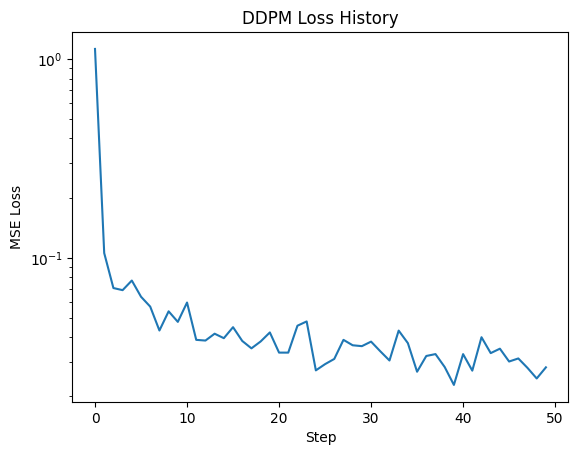

In [41]:
plt.plot(losses)
plt.title("DDPM Loss History")
plt.yscale('log')
plt.ylabel('MSE Loss')
plt.xlabel('Step')
plt.show()

## Inferencing the model
See sample() in DDPM for more information

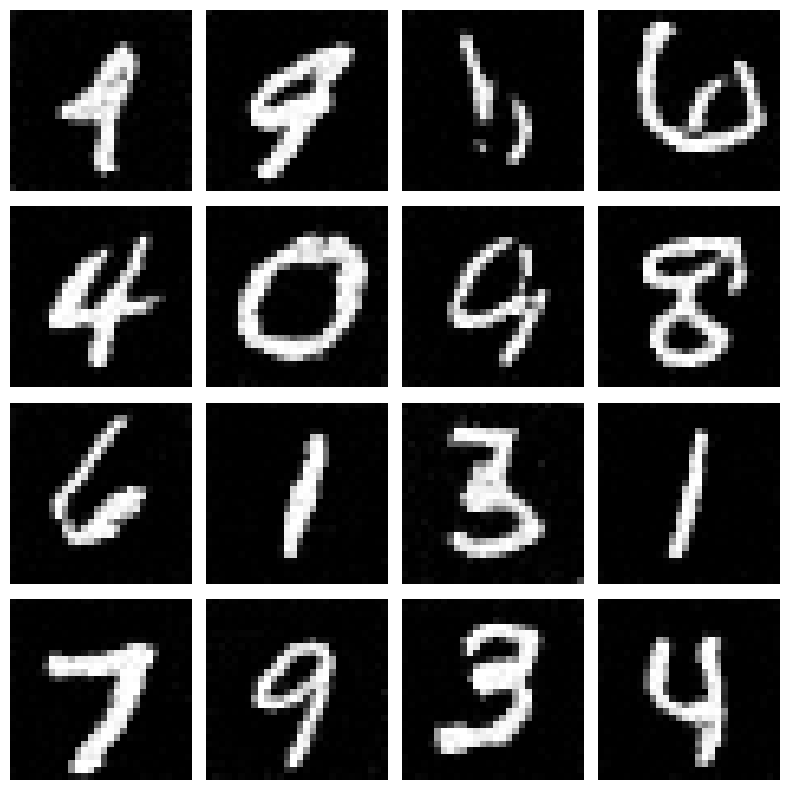

In [39]:
# Generate & display samples
def display_samples(samples):
    samples = samples.cpu().numpy()
    n = int(samples.shape[0] ** 0.5)
    fig, axes = plt.subplots(n, n, figsize=(8, 8))
    for i in range(n):
        for j in range(n):
            idx = i * n + j
            if idx < samples.shape[0]:
                axes[i, j].imshow(samples[idx, 0], cmap='gray')
                axes[i, j].axis('off')
                
    plt.tight_layout()
    plt.show()

samples = sample(model, n_samples=16).cpu()
display_samples(samples)
